In [135]:
!pip install pmdarima

In [178]:
!pip install smape_loss

ERROR: Could not find a version that satisfies the requirement smape_loss (from versions: none)
ERROR: No matching distribution found for smape_loss


In [136]:
!pip install sktime.performance_metrics

ERROR: Could not find a version that satisfies the requirement sktime.performance_metrics (from versions: none)
ERROR: No matching distribution found for sktime.performance_metrics


In [137]:
!pip install sktime

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')

train = pd.read_csv('/content/drive/MyDrive/web-traffic-time-series-forecasting/train_2.csv', index_col=0)
print(f'{train.shape[0]} time series (rows): daily views of each web page')
print(f'{train.shape[1]} days (columns): from {train.columns.min()} to {train.columns.max()}')
train.head(1)

145063 time series (rows): daily views of each web page
803 days (columns): from 2015-07-01 to 2017-09-10


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Page,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0


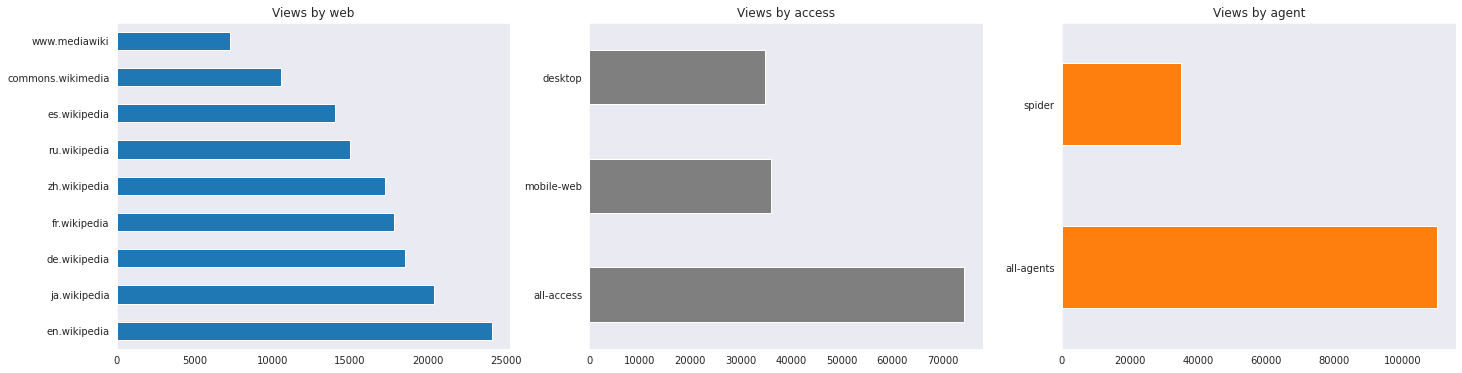

In [139]:
page_details = train.index.str.extract(r'(?P<topic>.*)\_(?P<web>.*).org\_(?P<access>.*)\_(?P<agent>.*)')
plt.figure(figsize=(24,6))
j = 1
c = ['tab:blue', 'tab:grey', 'tab:orange']
for i in page_details.columns[1:]: 
    plt.subplot(1,3,j)
    page_details[i].value_counts().plot(kind='barh', color=c[j-1])
    plt.title('Views by '+i)
    j+=1

EDA

In [140]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

en = train.iloc[page_details[page_details['web'] == 'en.wikipedia'].index, :].sum()
en.index = pd.to_datetime(en.index)
en_dif = (en - en.shift(1)).iloc[1:,]

es = train.iloc[page_details[page_details['web'] == 'es.wikipedia'].index, :].sum()
es.index = pd.to_datetime(es.index)
es_dif = (es - es.shift(1)).iloc[1:,]

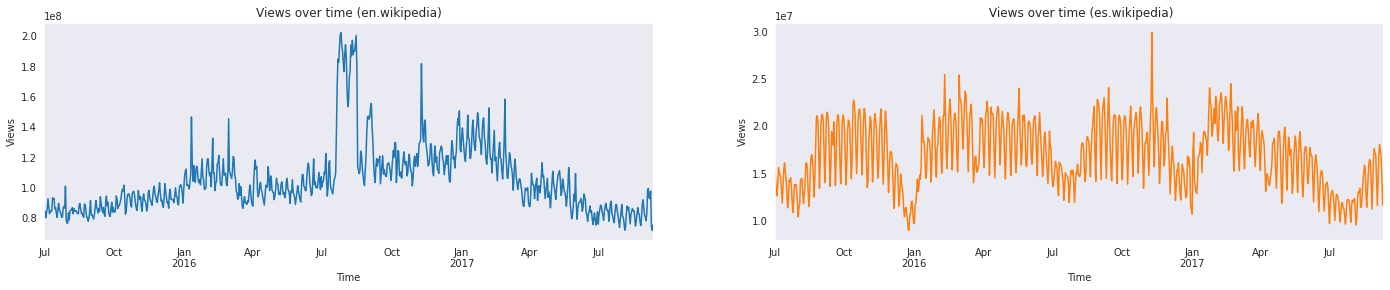

In [141]:
plt.figure(figsize=(24,4))
plt.subplot(121)
en.plot(title='Views over time (en.wikipedia)', xlabel='Time', ylabel='Views')
plt.subplot(122)
es.plot(title=' Views over time (es.wikipedia)', xlabel='Time', ylabel='Views', color='#ff7f0e')

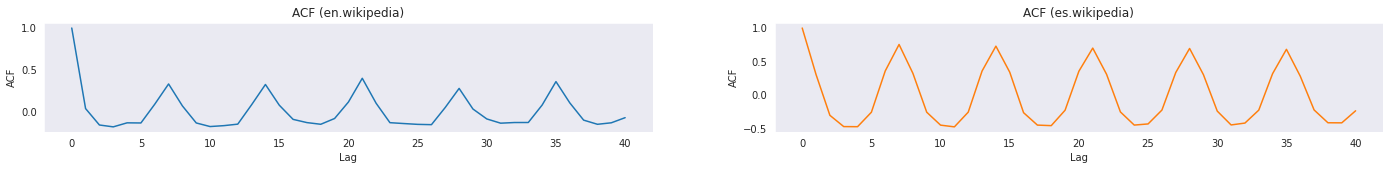

In [142]:
plt.figure(figsize=(24,2))
plt.subplot(121)
pd.Series(acf(en_dif)).plot(title='ACF (en.wikipedia)', xlabel='Lag', ylabel='ACF')
plt.subplot(122)
pd.Series(acf(es_dif)).plot(title='ACF (es.wikipedia)', xlabel='Lag', ylabel='ACF', color='#ff7f0e')

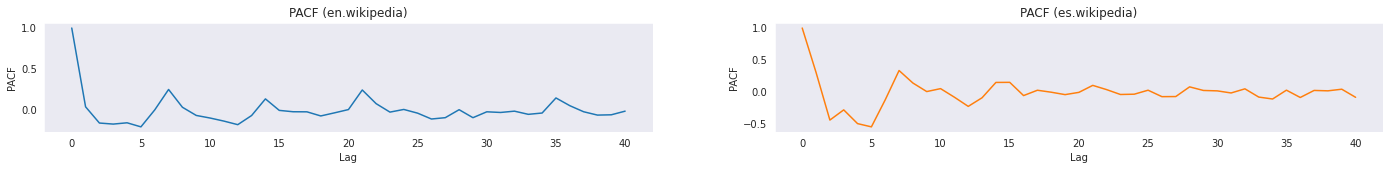

In [143]:
plt.figure(figsize=(24,2))
plt.subplot(121)
pd.Series(pacf(en_dif)).plot(title='PACF (en.wikipedia)', xlabel='Lag', ylabel='PACF')
plt.subplot(122)
pd.Series(pacf(es_dif)).plot(title='PACF (es.wikipedia)', xlabel='Lag', ylabel='PACF', color='#ff7f0e')

Text(0.5, 0, 'Time')

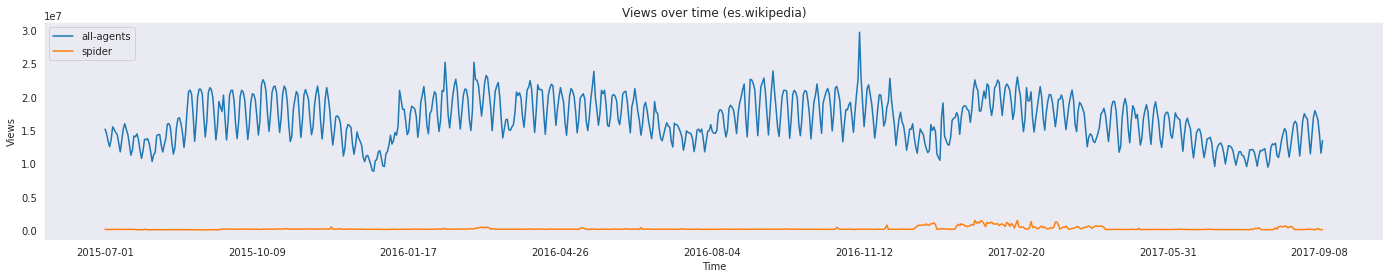

In [144]:
for i in np.unique(page_details['agent']): train.iloc[page_details[(page_details['agent'] == i) & (page_details['web'] == 'es.wikipedia')].index, :].sum().plot(label=i, figsize=(24,4))
plt.legend(loc='upper left')
plt.title('Views over time (es.wikipedia)')
plt.ylabel('Views')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

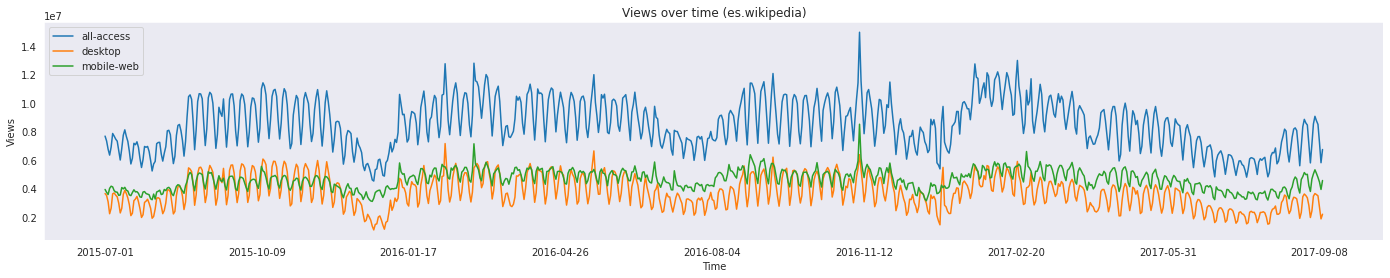

In [145]:
for i in np.unique(page_details['access']): train.iloc[page_details[(page_details['access'] == i) & (page_details['web'] == 'es.wikipedia')].index, :].sum().plot(label=i, figsize=(24,4))
plt.legend(loc='upper left')
plt.title('Views over time (es.wikipedia)')
plt.ylabel('Views')
plt.xlabel('Time')

Feature Engineer

9.3% web pages (329 out of 3537) have one or more missing value


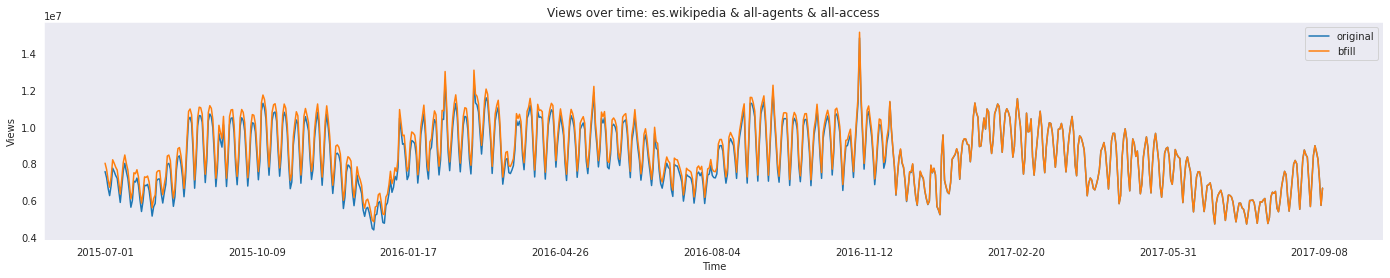

In [146]:
df = (page_details['access'] == 'all-access') & (page_details['agent'] == 'all-agents') & (page_details['web'] == 'es.wikipedia')
df = train.iloc[df[df].index,:]

na_num = sum(df.isna().sum(axis=1) != 0)
num = df.shape[0]
print(f'{round(na_num/num*100, 1)}% web pages ({na_num} out of {num}) have one or more missing value')

original = df.sum()
bfill = df.T.fillna(method='bfill').T.sum()
original.plot(figsize=(24,4), title='Views over time: es.wikipedia & all-agents & all-access', ylabel='Views', xlabel='Time', label='original')
bfill.plot(label='bfill')
plt.legend()

In [147]:
df = bfill.to_frame('Views').reset_index().rename(columns={'index': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Views
0,2015-07-01,8022174.0
1,2015-07-02,7687790.0
2,2015-07-03,7121842.0
3,2015-07-04,6720181.0
4,2015-07-05,7275102.0
...,...,...
798,2017-09-06,8638762.0
799,2017-09-07,8234557.0
800,2017-09-08,7135816.0
801,2017-09-09,5737143.0


In [148]:
y = df.set_index('Date')
y

,Views
Date,
2015-07-01,8022174.0
2015-07-02,7687790.0
2015-07-03,7121842.0
2015-07-04,6720181.0
2015-07-05,7275102.0
...,...
2017-09-06,8638762.0
2017-09-07,8234557.0
2017-09-08,7135816.0


In [171]:
y.index = pd.DatetimeIndex(y.index).to_period('D')


In [172]:
y_train = y[:-60]
y_train = y_train['Views']
y_train.shape


(743,)

In [173]:
y_test = y[-60:]
y_test = y_test['Views']
y_test.shape



(60,)

In [174]:
y_train.index.min(), y_train.index.max()

(Period('2015-07-01', 'D'), Period('2017-07-12', 'D'))

In [175]:
from sktime.forecasting.arima import ARIMA
arima_model = ARIMA(order=(4,2,1))
arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

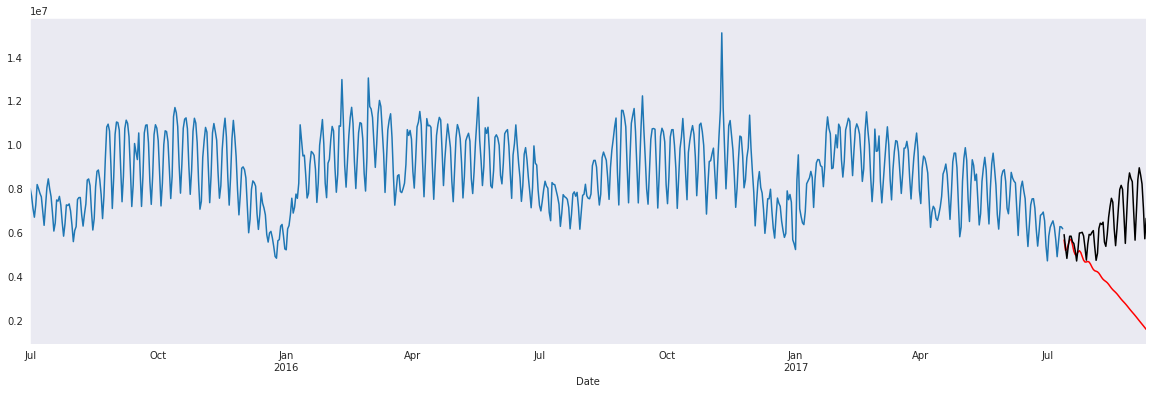

In [187]:
y_train.plot(figsize = (20,6))
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [179]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test, y_pred)*100
print(mape)

269083154.5557742


In [181]:
np.mean(np.abs(y_pred - y_test))

2690831.545557742

In [182]:
#MAE
np.mean(np.abs(y_pred - y_test))

2690831.545557742

In [183]:
#MAPE
np.mean(np.abs(y_pred - y_test)/np.abs(y_test))

0.38108849443770837

In [ ]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [184]:
#sMAPE
smape = smape(y_pred, y_test)
smape

53.69415208691536